Исследована работа небольшой сети (10 эпох, 10 нейронов внутреннего слоя) с разными оптимизаторами (Adam, SGD, RMSProp, Adagrad) и "добавками" (BatchNorm, Dropout). *(Графики представлены в конце блокнота)*

**Выводы:**
1. При использовании сети с нормализацией и дропаутом модели с RMS, SGD, Adam сходятся примерно одинаково; с SGD учится чуть медленнее; Adagrad показал результаты похуже (по MSE и скорости обучения), но в целом неплохие.

2. Если убрать Dropout, финальные результаты меняются незначительно. Adam и RMS показывают результаты немножко хуже: видимо, они достаточно быстро обучаются и Dropout их спасал от переобучения. SGD и Adagrad наоборот показывают результаты лучше, что можно объяснить тем, что они в целом обучаются медленнее и dropout их тормозил при таких небольших размерах сети. Финальный результат Adagrad получился даже немного лучше, чем в присутствии dropout

3. Если убрать нормализацию, результаты сильно ухудшаются для всех моделей, что логично: поступающие данные абсолютно разные по величине. Это оказывает особенно негативное влияние в случае задачи регрессии. Данные необходимо нормализовать. Модель с Adagrad в данном случае вообще ушла в разнос

**Итог:**
Лучше всех справились оптимизаторы Adam и RMSProp, они показали лучшую скорость обучения и соответственно финальные результаты. Ввиду высокой скорости обучения слой Dropout для них очень даже полезен. Ввиду типа задачи (регрессия) слой BatchNorm жизненно необходим.

1. Создать Dataset для загрузки данных (sklearn.datasets.fetch_california_housing)
2. Обернуть его в Dataloader
3. Написать архитектуру сети, которая предсказывает стоимость недвижимости. Сеть должна включать BatchNorm слои и Dropout (или НЕ включать, но нужно обосновать)
4. Сравните сходимость Adam, RMSProp и SGD, сделайте вывод по качеству работы модели
train-test разделение нужно сделать с помощью sklearn random_state=13, test_size = 0.25

In [1]:
import math
import torch
from sklearn.datasets import fetch_california_housing
from torchvision import transforms, datasets
import torch.nn.functional as F
import torch.nn as nn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [2]:
dataset =  fetch_california_housing()#.data

In [3]:
X_train, X_test, y_train, y_test = train_test_split(dataset.data, dataset.target, test_size=0.25, random_state=13)

In [4]:
class CaliforniaHousing(torch.utils.data.Dataset):

    def __init__(self, init_data, init_target):
        self._base_data = init_data
        self._base_target = init_target
        # self.transform = transform

    def __len__(self):
        return self._base_data.shape[0]

    def __getitem__(self, idx):
        x = self._base_data[idx]#.values
        y = self._base_target[idx]

        return torch.tensor(x).float(), torch.tensor(y).float()


train_dataset = CaliforniaHousing(X_train, y_train)
test_dataset = CaliforniaHousing(X_test, y_test)

In [5]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=128,
                          shuffle=True,
                          num_workers=1)

In [6]:
test_loader = torch.utils.data.DataLoader(test_dataset,
                          batch_size=128,
                          shuffle=True,
                          num_workers=1)

In [7]:
for batch, label in test_loader:
    print(batch.shape)
    print(label.shape)#reshape(label.shape[0], 1).shape)
    break

torch.Size([128, 8])
torch.Size([128])


In [8]:
class Perceptron(nn.Module):
    def __init__(self, input_dim, output_dim, activation="relu"):
        super(Perceptron, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        self.activation = activation

    def forward(self, x):
        x = self.fc(x)
        if self.activation=="relu":
            return F.relu(x)
        if self.activation=="leakyrelu":
            return F.leaky_relu(x)
        raise RuntimeError


class FeedForward_BN_DO(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(FeedForward_BN_DO, self).__init__()
        self.bn1 = nn.BatchNorm1d(input_dim)
        self.fc1 = Perceptron(input_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.dp = nn.Dropout(0.25)
        self.fc2 = Perceptron(hidden_dim, 1, "relu")

    def forward(self, x):
        x = self.bn1(x)
        x = self.fc1(x)
        x = self.bn2(x)
        x = self.dp(x)
        x = self.fc2(x)
        return x

class FeedForward_DO(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(FeedForward_DO, self).__init__()
        self.fc1 = Perceptron(input_dim, hidden_dim)
        self.dp = nn.Dropout(0.25)
        self.fc2 = Perceptron(hidden_dim, 1, "relu")

    def forward(self, x):
        x = self.fc1(x)
        x = self.dp(x)
        x = self.fc2(x)
        return x
class FeedForward_BN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(FeedForward_BN, self).__init__()
        self.bn1 = nn.BatchNorm1d(input_dim)
        self.fc1 = Perceptron(input_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = Perceptron(hidden_dim, 1, "relu")

    def forward(self, x):
        x = self.bn1(x)
        x = self.fc1(x)
        x = self.bn2(x)
        x = self.fc2(x)
        return x

In [9]:
def training(train_loader, test_loader, net, optimizer, loss_fn=nn.MSELoss(), epochs=20):
  train_loss_hist = []
  test_loss_hist = []
  best_loss = {'train': None, 'train epoch': None, 'test': None, 'test epoch': None}
  net.train()
  for epoch in range(epochs):
    running_loss, num = 0.0, 0.0
    for i, (inputs, labels) in enumerate(train_loader):

        outputs = net(inputs)
        loss = loss_fn(outputs.reshape(outputs.shape[0]), labels)

        # обнуляем градиент
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        num += len(labels)
        # выводим статистику о процессе обучения
        if i % 120 == 0:    # печатаем каждые 150 mini-batches
            net.eval()

            test_loss, test_num = 0.0, 0.0
            for y, (inputs_test, labels_test) in enumerate(test_loader):
                test_outputs = net(inputs_test)
                test_loss += loss_fn(test_outputs.reshape(test_outputs.shape[0]), labels_test)
                test_num += len(labels_test)

            res_loss_train = running_loss / num
            res_loss_test = (test_loss / test_num).detach().numpy()

            if best_loss['train'] is None or res_loss_train < best_loss['train']:
              best_loss['train'] = res_loss_train
              best_loss['train epoch'] = epoch

            if best_loss['test'] is None or res_loss_test < best_loss['test']:
              best_loss['test'] = res_loss_train
              best_loss['test epoch'] = epoch

            # print(f'Epoch [{epoch + 1}/{epochs}]. ' \
            #       f'Step [{i + 1}/{len(train_loader)}]. ' \
            #       f'Train mse: {res_loss_train:.3f}. '\
            #       f'Test mse: {res_loss_test:.3f}.')
            train_loss_hist.append(res_loss_train)
            test_loss_hist.append(res_loss_test)
            running_loss, num = 0.0, 0.0
            net.train()
  print(f"Best mse train: {best_loss['train']:.3f} ({best_loss['train epoch']} epoch)")
  print(f"Best mse test: {best_loss['test']:.3f} ({best_loss['test epoch']} epoch)")
  print('Training is finished!')
  return train_loss_hist, test_loss_hist

In [10]:
inner_layer = 10
epochs = 10
criterion = nn.MSELoss()

In [11]:
net = FeedForward_BN_DO(X_train.shape[1], inner_layer)
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
sgd_tr_plot, sgd_ts_plot = training(train_loader, test_loader, net, optimizer,criterion,epochs)

Best mse train: 0.003 (8 epoch)
Best mse test: 0.004 (9 epoch)
Training is finished!


In [12]:
net = FeedForward_BN_DO(X_train.shape[1], inner_layer)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
adam_tr_plot, adam_ts_plot = training(train_loader, test_loader, net, optimizer,criterion,epochs)

Best mse train: 0.003 (2 epoch)
Best mse test: 0.003 (2 epoch)
Training is finished!


In [13]:
net = FeedForward_BN_DO(X_train.shape[1], inner_layer)
optimizer = torch.optim.RMSprop(net.parameters(), lr=0.01)
rms_tr_plot, rms_ts_plot = training(train_loader, test_loader, net, optimizer,criterion,epochs)

Best mse train: 0.003 (8 epoch)
Best mse test: 0.004 (5 epoch)
Training is finished!


In [14]:
net = FeedForward_BN_DO(X_train.shape[1], inner_layer)
optimizer = torch.optim.Adagrad(net.parameters(), lr=0.01)
adagr_tr_plot, adagr_ts_plot = training(train_loader, test_loader, net, optimizer,criterion,epochs)

Best mse train: 0.005 (4 epoch)
Best mse test: 0.006 (9 epoch)
Training is finished!


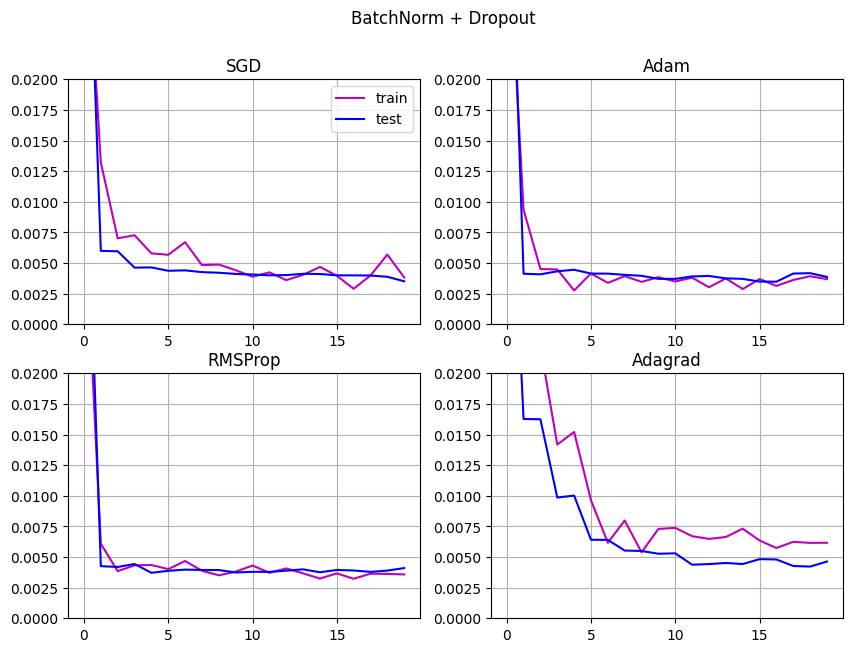

In [15]:
figure, axis = plt.subplots(2, 2)
figure.set_size_inches(10,7)
figure.suptitle('BatchNorm + Dropout')

# SGD
axis[0, 0].set_ylim(0,0.02)
axis[0, 0].plot(range(epochs*2), sgd_tr_plot,color='m', label='train')
axis[0, 0].plot(range(epochs*2), sgd_ts_plot,color='b', label='test')
axis[0, 0].set_title("SGD")
axis[0, 0].grid()
axis[0, 0].legend()

# Adam
axis[0, 1].set_ylim(0,0.02)
axis[0, 1].plot(range(epochs*2), adam_tr_plot,color='m', label='train')
axis[0, 1].plot(range(epochs*2), adam_ts_plot,color='b', label='test')
axis[0, 1].set_title("Adam")
axis[0, 1].grid()

# RMSProp
axis[1, 0].set_ylim(0,0.02)
axis[1, 0].plot(range(epochs*2), rms_tr_plot,color='m', label='train')
axis[1, 0].plot(range(epochs*2), rms_ts_plot,color='b', label='test')
axis[1, 0].set_title("RMSProp")
axis[1, 0].grid()

# Adagrad
axis[1, 1].set_ylim(0,0.02)
axis[1, 1].plot(range(epochs*2), adagr_tr_plot,color='m', label='train')
axis[1, 1].plot(range(epochs*2), adagr_ts_plot,color='b', label='test')
axis[1, 1].set_title("Adagrad")
axis[1, 1].grid()

# Combine all the operations and display
plt.show()

In [16]:
net = FeedForward_BN(X_train.shape[1], inner_layer)
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
sgd_tr_plot, sgd_ts_plot = training(train_loader, test_loader, net, optimizer,criterion,epochs)

net = FeedForward_BN(X_train.shape[1], inner_layer)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
adam_tr_plot, adam_ts_plot = training(train_loader, test_loader, net, optimizer,criterion,epochs)

net = FeedForward_BN(X_train.shape[1], inner_layer)
optimizer = torch.optim.RMSprop(net.parameters(), lr=0.01)
rms_tr_plot, rms_ts_plot = training(train_loader, test_loader, net, optimizer,criterion,epochs)

net = FeedForward_BN(X_train.shape[1], inner_layer)
optimizer = torch.optim.Adagrad(net.parameters(), lr=0.01)
adagr_tr_plot, adagr_ts_plot = training(train_loader, test_loader, net, optimizer,criterion,epochs)

Best mse train: 0.003 (3 epoch)
Best mse test: 0.003 (5 epoch)
Training is finished!
Best mse train: 0.003 (6 epoch)
Best mse test: 0.003 (1 epoch)
Training is finished!
Best mse train: 0.003 (7 epoch)
Best mse test: 0.003 (1 epoch)
Training is finished!
Best mse train: 0.003 (9 epoch)
Best mse test: 0.003 (5 epoch)
Training is finished!


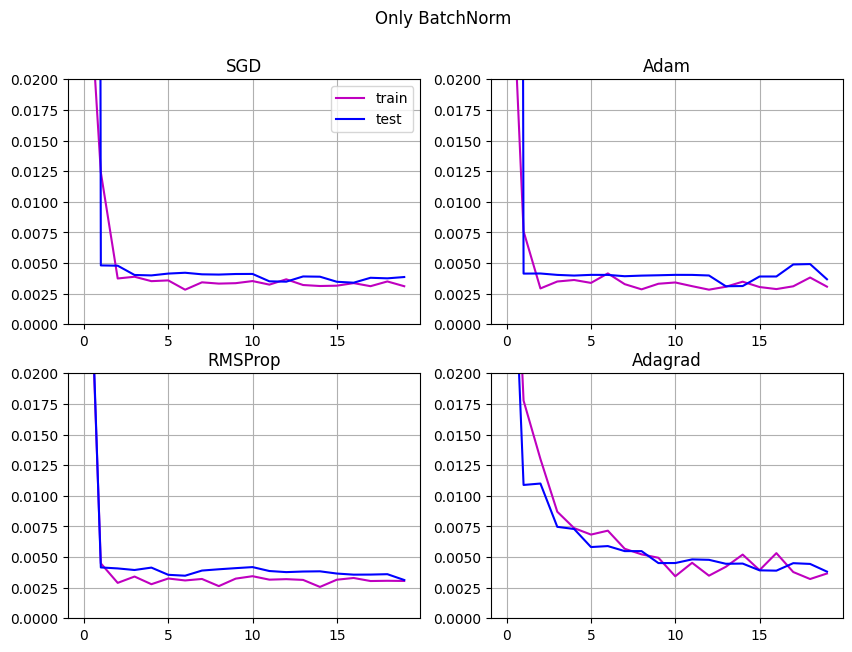

In [17]:
figure, axis = plt.subplots(2, 2)
figure.set_size_inches(10,7)
figure.suptitle('Only BatchNorm')

# SGD
axis[0, 0].set_ylim(0,0.02)
axis[0, 0].plot(range(epochs*2), sgd_tr_plot,color='m', label='train')
axis[0, 0].plot(range(epochs*2), sgd_ts_plot,color='b', label='test')
axis[0, 0].set_title("SGD")
axis[0, 0].grid()
axis[0, 0].legend()

# Adam
axis[0, 1].set_ylim(0,0.02)
axis[0, 1].plot(range(epochs*2), adam_tr_plot,color='m', label='train')
axis[0, 1].plot(range(epochs*2), adam_ts_plot,color='b', label='test')
axis[0, 1].set_title("Adam")
axis[0, 1].grid()

# RMSProp
axis[1, 0].set_ylim(0,0.02)
axis[1, 0].plot(range(epochs*2), rms_tr_plot,color='m', label='train')
axis[1, 0].plot(range(epochs*2), rms_ts_plot,color='b', label='test')
axis[1, 0].set_title("RMSProp")
axis[1, 0].grid()

# Adagrad
axis[1, 1].set_ylim(0,0.02)
axis[1, 1].plot(range(epochs*2), adagr_tr_plot,color='m', label='train')
axis[1, 1].plot(range(epochs*2), adagr_ts_plot,color='b', label='test')
axis[1, 1].set_title("Adagrad")
axis[1, 1].grid()

# Combine all the operations and display
plt.show()

In [18]:
net = FeedForward_DO(X_train.shape[1], inner_layer)
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
sgd_tr_plot, sgd_ts_plot = training(train_loader, test_loader, net, optimizer,criterion,epochs)

net = FeedForward_DO(X_train.shape[1], inner_layer)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
adam_tr_plot, adam_ts_plot = training(train_loader, test_loader, net, optimizer,criterion,epochs)

net = FeedForward_DO(X_train.shape[1], inner_layer)
optimizer = torch.optim.RMSprop(net.parameters(), lr=0.01)
rms_tr_plot, rms_ts_plot = training(train_loader, test_loader, net, optimizer,criterion,epochs)

net = FeedForward_DO(X_train.shape[1], inner_layer)
optimizer = torch.optim.Adagrad(net.parameters(), lr=0.01)
adagr_tr_plot, adagr_ts_plot = training(train_loader, test_loader, net, optimizer,criterion,epochs)

Best mse train: 0.035 (5 epoch)
Best mse test: 0.044 (0 epoch)
Training is finished!
Best mse train: 0.034 (1 epoch)
Best mse test: 0.034 (1 epoch)
Training is finished!
Best mse train: 0.039 (5 epoch)
Best mse test: 0.043 (1 epoch)
Training is finished!
Best mse train: 0.093 (1 epoch)
Best mse test: 0.412 (9 epoch)
Training is finished!


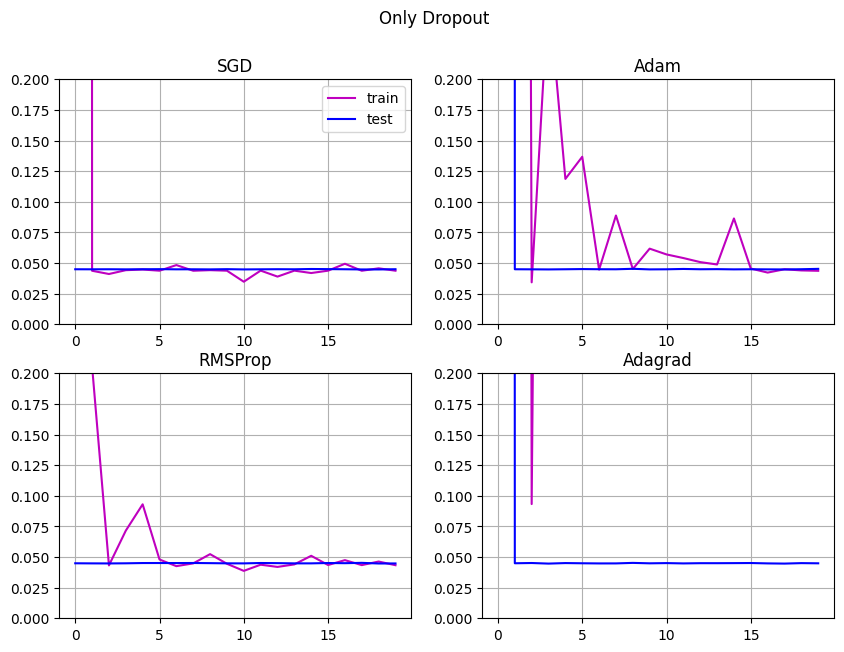

In [22]:
figure, axis = plt.subplots(2, 2)
figure.set_size_inches(10,7)
figure.suptitle('Only Dropout')

# SGD
axis[0, 0].set_ylim(0,0.2)
axis[0, 0].plot(range(epochs*2), sgd_tr_plot,color='m', label='train')
axis[0, 0].plot(range(epochs*2), sgd_ts_plot,color='b', label='test')
axis[0, 0].set_title("SGD")
axis[0, 0].grid()
axis[0, 0].legend()

# Adam
axis[0, 1].set_ylim(0,0.2)
axis[0, 1].plot(range(epochs*2), adam_tr_plot,color='m', label='train')
axis[0, 1].plot(range(epochs*2), adam_ts_plot,color='b', label='test')
axis[0, 1].set_title("Adam")
axis[0, 1].grid()

# RMSProp
axis[1, 0].set_ylim(0,0.2)
axis[1, 0].plot(range(epochs*2), rms_tr_plot,color='m', label='train')
axis[1, 0].plot(range(epochs*2), rms_ts_plot,color='b', label='test')
axis[1, 0].set_title("RMSProp")
axis[1, 0].grid()

# Adagrad
axis[1, 1].set_ylim(0,0.2)
axis[1, 1].plot(range(epochs*2), adagr_tr_plot,color='m', label='train')
axis[1, 1].plot(range(epochs*2), adagr_ts_plot,color='b', label='test')
axis[1, 1].set_title("Adagrad")
axis[1, 1].grid()

# Combine all the operations and display
plt.show()